#### 1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта.
#### 2. при обучении моделей обязательно использовать кроссвалидацию.
#### 3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики).
#### 4. сделать выводы о том, какая модель справилась с задачей лучше других.

In [20]:
import numpy as np

import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from catboost import CatBoostClassifier

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

In [21]:
df = pd.read_csv('train_case2.csv', ';')

In [22]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [26]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [27]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [28]:
b=1
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_test.values, y_score)
fscore_0 = (1+b**2)*(precision_0 * recall_0) / (b**2*precision_0 + recall_0)
ix = np.argmax(fscore_0)
print('Best Threshold=%f, F-Score_0=%.3f, Precision_0=%.3f, Recall_0=%.3f' % (thresholds_0[ix], 
                                                                        fscore_0[ix],
                                                                        precision_0[ix],
                                                                        recall_0[ix]))

Best Threshold=0.386937, F-Score_0=0.730, Precision_0=0.647, Recall_0=0.838


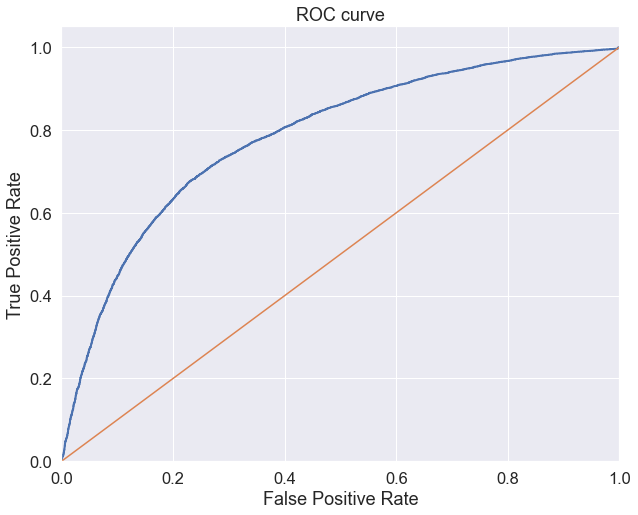

In [29]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Обучим модель при помощи случайного леса.

In [30]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100)),
])

cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7741300870273617+-0.007992331998620143


In [31]:
b=1
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test.values, y_score)
fscore_1 = (1+b**2)*(precision_1 * recall_1) / (b**2*precision_1 + recall_1)
# locate the index of the largest f score
ix = np.argmax(fscore_1)
print('Best Threshold=%f, F-Score_1=%.3f, Precision_1=%.3f, Recall_1=%.3f' % (thresholds_1[ix], 
                                                                        fscore_1[ix],
                                                                        precision_1[ix],
                                                                        recall_1[ix]))

Best Threshold=0.347500, F-Score_1=0.721, Precision_1=0.644, Recall_1=0.818


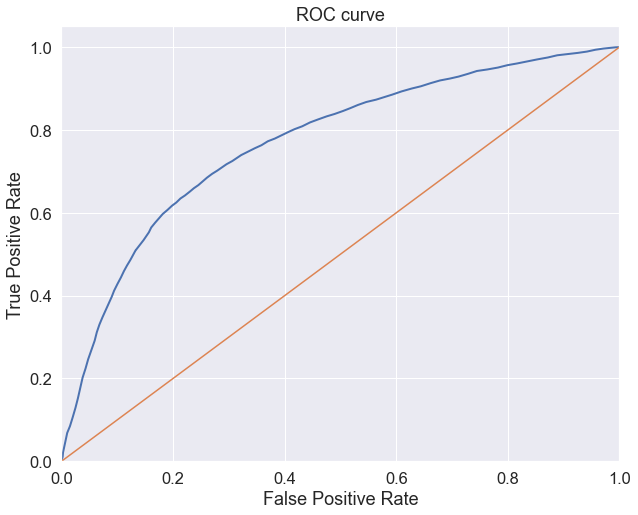

In [32]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

Проведем обучение при помощи грдиентного бустинга.

In [33]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1)),
])

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

0:	learn: 0.5840423	total: 3.29ms	remaining: 3.29ms
1:	learn: 0.5669115	total: 6.38ms	remaining: 0us
0:	learn: 0.5832995	total: 3.4ms	remaining: 3.4ms
1:	learn: 0.5660811	total: 7.52ms	remaining: 0us
0:	learn: 0.5859451	total: 3.87ms	remaining: 3.87ms
1:	learn: 0.5666089	total: 7.87ms	remaining: 0us
0:	learn: 0.5838505	total: 3.75ms	remaining: 3.75ms
1:	learn: 0.5663867	total: 6.84ms	remaining: 0us
0:	learn: 0.5860687	total: 5.22ms	remaining: 5.22ms
1:	learn: 0.5664959	total: 8.85ms	remaining: 0us
0:	learn: 0.5832239	total: 5.24ms	remaining: 5.24ms
1:	learn: 0.5661724	total: 9.32ms	remaining: 0us
0:	learn: 0.5830644	total: 4.64ms	remaining: 4.64ms
1:	learn: 0.5659264	total: 9.58ms	remaining: 0us
0:	learn: 0.5829679	total: 5.15ms	remaining: 5.15ms
1:	learn: 0.5691144	total: 9.53ms	remaining: 0us
0:	learn: 0.5841072	total: 4.13ms	remaining: 4.13ms
1:	learn: 0.5667664	total: 8.23ms	remaining: 0us
0:	learn: 0.5832189	total: 3.44ms	remaining: 3.44ms
1:	learn: 0.5657817	total: 7.83ms	remaini

In [34]:
b=1
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test.values, y_score)
fscore_2 = (1+b**2)*(precision_2 * recall_2) / (b**2*precision_2 + recall_2)
ix = np.argmax(fscore_2)
print('Best Threshold=%f, F-Score_2=%.3f, Precision_2=%.3f, Recall_2=%.3f' % (thresholds_2[ix], 
                                                                        fscore_2[ix],
                                                                        precision_2[ix],
                                                                        recall_2[ix]))

Best Threshold=0.368839, F-Score_2=0.721, Precision_2=0.601, Recall_2=0.902


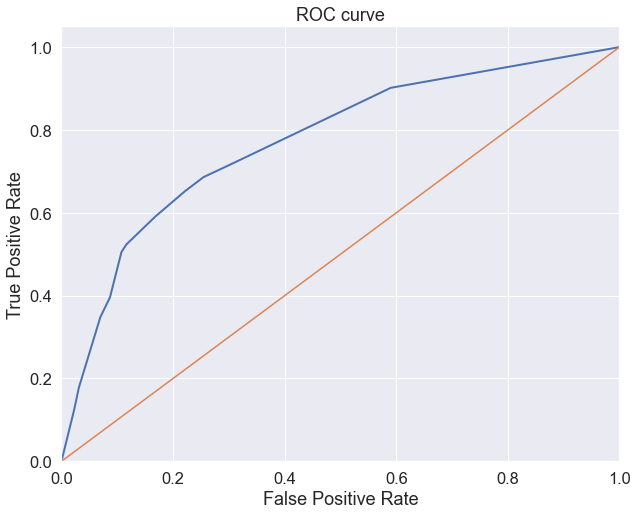

In [35]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [36]:
ix_0 = np.argmax(fscore_0)
ix_1 = np.argmax(fscore_1)
ix_2 = np.argmax(fscore_2)
index=['F-Score', 'Precision', 'Recall']

comparison = pd.DataFrame({'LogisticRegression':[fscore_0[ix_0], precision_0[ix_0], recall_0[ix_0]], 
                           'RandomForestClassifier':[fscore_1[ix_1], precision_1[ix_1], recall_1[ix_1]],
                           'CatBoostClassifier':[fscore_2[ix_2], precision_2[ix_2], recall_2[ix_2]]},
                           index=index)

comparison.T

,F-Score,Precision,Recall
LogisticRegression,0.730323,0.647431,0.837558
RandomForestClassifier,0.720649,0.643880,0.818203
CatBoostClassifier,0.720984,0.600599,0.901728


Полученные результаты неоднозначны- модель на основе градиентного бустинг имеет лучшие показатели F-Score и полноты, но при этом наименьшую точность. Полагаю, что при изменении параметров модели, можно улучшить данный показатель.